In [175]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator

In [176]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [177]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [178]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [179]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [180]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [181]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [182]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [183]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


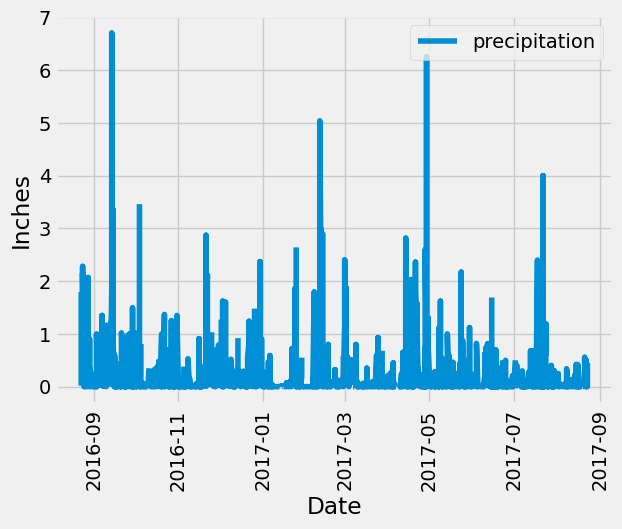

In [184]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
recent_date_str = recent_date[0]

# Convert recent date to datetime
this_year = dt.datetime.strptime(recent_date_str, "%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
last_year = this_year.replace(year=this_year.year - 1)

# Perform a query to retrieve the data and precipitation scores
data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date <= this_year)
    .filter(measurement.date >= last_year)
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_df = pd.DataFrame(data)
data_df["date"] = pd.to_datetime(data_df["date"], format="%Y-%m-%d")

# Sort the dataframe by date
data_df = data_df.sort_values(by="date", ascending=False)
# print(type(data_df.date[0]))
data_df

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(data_df["date"], data_df["prcp"], label="precipitation")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [185]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = data_df["prcp"].describe()

summary_stats = pd.DataFrame(summary_stats)

summary_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [186]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).distinct().count()

print(f"Toal stations: {total_stations}")


Toal stations: 9


In [187]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = (
    session.query(measurement.station, func.count().label("count"))
    .group_by(measurement.station)
    .order_by(func.count().desc())
    .all()
)

most_active_count_df = pd.DataFrame([(entry.station, entry.count) for entry in most_active], columns=["Station", "Count"])

most_active_count_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [188]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = most_active[0][0]

most_active_data = (
    session.query(measurement.tobs).filter(measurement.station == most_active_id).all()
)

most_active_df = pd.DataFrame(most_active_data)

lowest_temp = most_active_df["tobs"].min()
highest_temp = most_active_df["tobs"].max()
avg_temp = most_active_df["tobs"].mean()

print(f"Low: {lowest_temp}, High: {highest_temp}, Avg: {avg_temp}")

Low: 54.0, High: 85.0, Avg: 71.66378066378067


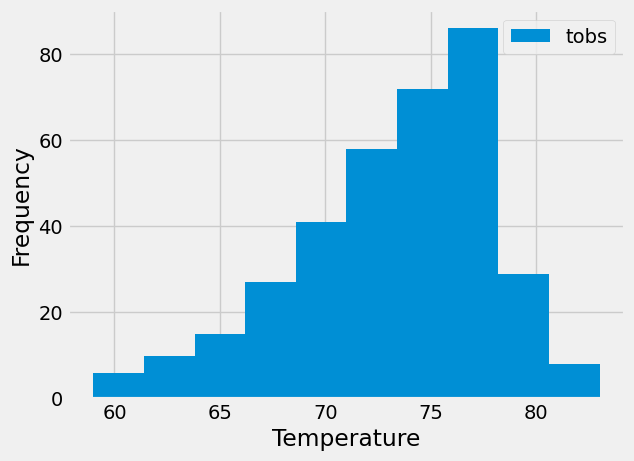

In [189]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_id)
    .filter(measurement.date <= this_year)
    .filter(measurement.date >= last_year)
    .all()
)

data_df = pd.DataFrame(data)

plt.hist(data_df["tobs"], label="tobs")
plt.legend(loc="best")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [190]:
# Close Session
session.close()